In [44]:
"Reproduce voigt 2012 results"
import galsim
import numpy as np
from astropy.utils.console import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline
from lmfit import minimize, Minimizer,Parameters, Parameter, report_fit, report_errors,fit_report

In [45]:
def make_Euclid_filter(res=1.0):
    """ Make a Euclid-like filter (eye-balling Semboloni++13).
    @param res  Resolution in nanometers.
    @returns    galsim.Bandpass object.
    """
    x = [550.0, 750.0, 850.0, 900.0]
    y = [0.3, 0.3, 0.275, 0.2]
    tab = galsim.LookupTable(x, y, interpolant='linear')
    w = np.arange(550.0, 900.01, res)
    return galsim.Bandpass(galsim.LookupTable(w, tab(w), interpolant='linear'))

In [46]:
def get_LSST_filter():
    datapath = 'data/'
    filter_names ='ugrizy'  
    filters={}
    for filter_name in filter_names:
        filter_filename = datapath+'LSST_{}.dat'.format(filter_name)
        filters[filter_name] = galsim.Bandpass(filter_filename)
        filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)  
    return filters

In [47]:
def get_SEDs(args):
    """ Return obs-frame bulge, disk and composite SEDs given command line arguments.
    @param args          A command line argument object with the following attributes:
        args.disk_SED    One of ['Sbc', 'Scd', 'Im', 'E'] to indicate disk SED.
        args.redshift    Redshift of galaxy (both bulge and disk)
        args.bulge_frac  Fraction of flux in bulge component at 550 nm rest-frame.
    @returns  bulge_SED, disk_SED, composite_SED.
    """
    pth='data/'
    b_SED = galsim.SED(pth+"CWW_E_ext.sed", wave_type='Ang')
    d_SED = galsim.SED(pth+"CWW_{}_ext.sed".format(args.disk_SED), wave_type='Ang')
    # Scale SEDs to 1.0, which means we must scale spatial component elsewhere to make
    # args.bulge_frac true in images.
    b_SED = b_SED.withFluxDensity(1.0, 550.0).atRedshift(args.redshift)
    d_SED = d_SED.withFluxDensity(1.0, 550.0).atRedshift(args.redshift)
    c_SED = b_SED * args.bulge_frac + d_SED * (1. - args.bulge_frac)

    return b_SED, d_SED, c_SED



In [48]:

def get_PSF(args):
    """ Return a Euclid-like chromatic PSF.
    @param args       A command line argument object with the following attributes:
        args.sig550   Gaussian width (sigma) of PSF at 550 nm.
        args.alpha    PSF wavelength scaling exponent.  1.0 for diffraction limit,
                      -0.2 for Kolmogorov turbulence.
    @returns  Euclid chromatic PSF.
    """
    mono_PSF = galsim.Gaussian(fwhm=args.fwhm550)
    chr_PSF = galsim.ChromaticObject(mono_PSF).dilate(lambda w: (w/550.0)**args.alpha)
    return chr_PSF

In [70]:
def get_gal_nocg(args, gal_cg, chr_PSF):
    """ Construct galaxy surface brightness profile with no color gradients that yields the same
    image as a given galaxy surface brightness profile with color gradients.

    @param args     A command line argument object with the following attributes:
        args.npix   Number of pixels across square postage stamp image.
        args.scale  Pixel scale for postage stamp image.
        args.bp     GalSIm Bandpass describing filter.
    @param gal_cg   GalSim GSObject describing galaxy chromatic s.b. profile.
    @param chr_PSF  GalSim ChromaticObject describing PSF.
    @returns        GalSim ChromaticObject of color-gradient-free galaxy.
    """
    psf_eff_img = (chr_PSF*args.c_SED).drawImage(args.bp, nx=args.npix*4.0, ny=args.npix*4.0,
                                    scale=args.scale/4.0, method='no_pixel')
    psf_eff = galsim.InterpolatedImage(psf_eff_img, calculate_stepk=False, calculate_maxk=False)
    gal_cg_eff_img = (galsim.Convolve(gal_cg,chr_PSF)).drawImage(args.bp, nx=args.npix*4.0, ny=args.npix*4.0,
                                    scale=args.scale/4.0, method='no_pixel')
    gal_cg_eff = galsim.InterpolatedImage(gal_cg_eff_img, calculate_stepk=False, calculate_maxk=False)
    gal_nocg = galsim.Convolve(gal_cg_eff, galsim.Deconvolve(psf_eff))
    return gal_nocg*args.c_SED


def get_gal_cg(args):
    bulge=(galsim.Sersic(n=args.bulge_n, half_light_radius=args.bulge_HLR,flux=args.T_flux*args.bulge_frac).shear(e1=args.bulge_e))
    disk=(galsim.Sersic(n=args.disk_n, half_light_radius=args.disk_HLR,flux=args.T_flux*(1-args.bulge_frac)).shear(e1=args.disk_e))
    gal=(bulge * args.b_SED)+(disk*args.d_SED)
    return gal
def get_gal_cg(args):
    bulge=(galsim.Sersic(n=args.bulge_n, half_light_radius=args.bulge_HLR,flux=args.T_flux).shear(e1=args.bulge_e))
    disk=(galsim.Sersic(n=args.disk_n, half_light_radius=args.disk_HLR,flux=args.T_flux).shear(e1=args.disk_e))
    gal=(bulge*args.bulge_frac * args.b_SED)+(disk*(1-args.bulge_frac)*args.d_SED)
    return gal
             




In [71]:
def get_moments(array):
    """ Compute second central moments of an array.
    @param array
    @returns Qxx, Qyy, Qxy second central moments of array.
    """
    nx, ny = array.shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    denom = np.sum(array)
    xbar = np.sum(array*x)/denom
    ybar = np.sum(array*y)/denom
    Qxx = np.sum(array*(x-xbar)**2)/denom
    Qyy = np.sum(array*(y-ybar)**2)/denom
    Qxy = np.sum(array*(x-xbar)*(y-ybar))/denom
    return Qxx, Qyy, Qxy





In [84]:
def estimate_shape(args, gal_img, PSF_img, method):
    """ Estimate the shape (ellipticity) of a galaxy.

    @param args     A command line argument object with the following attributes:
        args.sig_w  Width (sigma) of Gaussian weight function
        args.npix   Number of pixels across postage stamp image
        args.scale  Pixel scale of postage stamp image
    @param gal_img  A GalSim Image of the PSF-convolved galaxy
    @param PSF_img  A GalSim Image of the PSF
    @param method   Method to use to estimate shape.  One of:
        'S13'  Use Semboloni++13 observed second moments method (no PSF correction!)
        'REGAUSS', 'LINEAR', 'BJ', 'KSB'  Use GalSim.hsm module
    @returns galsim.Shear object holding galaxy ellipticity.
    """
    if method == 'S13':
        weight = galsim.Gaussian(sigma=args.hlr_w)
        weight_img = weight.drawImage(nx=args.npix, ny=args.npix, scale=args.scale)#,
                                      #method='no_pixel')
        Qxx, Qyy, Qxy = get_moments(weight_img.array * gal_img.array)
        R = Qxx + Qyy
        e1 = (Qxx-Qyy)/R
        e2 = 2*Qxy/R
        shape = galsim.Shear(e1=e1, e2=e2)
    elif method in ['REGAUSS', 'LINEAR', 'BJ']:
        result = galsim.hsm.EstimateShear(gal_img, PSF_img, shear_est=method)
        shape = galsim.Shear(e1=result.corrected_e1, e2=result.corrected_e2)
    elif method == 'KSB':
        result = galsim.hsm.EstimateShear(gal_img, PSF_img, shear_est=method)
        shape = galsim.Shear(g1=result.corrected_g1, g2=result.corrected_g2)
    elif method == 'fit':
        params=param_in(args)
        data=(gal_img.array).flatten()
        fit_kws={'maxfev':1000,'ftol':1.49012e-38,'xtol':1.49012e-38,}
        chr_psf=get_PSF(args)
        result=minimize(fcn2min,params,args=(data,args,chr_psf),**fit_kws)
        print result.chisqr
        shape=galsim.Shear(g1=params['g1'].value,g2=params['g2'].value)
        #print result.chi-square

    return shape



In [154]:
def cg_ring_test(args, gal_cg, gal_nocg, chr_PSF):
    """ Use a ring test to estimate multiplicative bias due to color-gradients.

    @param args         A command line argument object with the following attributes:
        args.npix       Number of pixels across postage stamp image
        args.scale      Pixel scale of postage stamp image
        args.n_ring     Number of intrinsic ellipticity pairs around ring.
        args.shear_est  Method to use to estimate shape.  See `estimate_shape` docstring.
        args.sig_w      For S13 method, the width (sigma) of the Gaussian weight funcion.
    @returns  Multiplicate bias estimate.
    """
    PSF_img = chr_PSF.drawImage(args.bp, nx=args.npix, ny=args.npix, scale=args.scale)
    n = len(args.rt_g) * args.n_ring * 2
    ghat_cg = []
    ghat_nocg = []
    with ProgressBar(n) as bar:
        for g1, g2 in args.rt_g:
            ehat_cg = []
            ehat_nocg = []
            for beta in np.linspace(0.0, 360.0, 2*args.n_ring, endpoint=False):
                gal_cg1 = gal_cg.rotate(beta*galsim.degrees).shear(g1=g1, g2=g2)
                gal_nocg1 = gal_nocg.rotate(beta*galsim.degrees).shear(g1=g1, g2=g2)
                obj_cg = galsim.Convolve(gal_cg1, chr_PSF)
                obj_nocg = galsim.Convolve(gal_nocg1, chr_PSF)
                img_cg = obj_cg.drawImage(bandpass=args.bp, nx=args.npix, ny=args.npix, scale=args.scale)
                img_nocg = obj_nocg.drawImage(args.bp, nx=args.npix, ny=args.npix, scale=args.scale)
                result_cg   = estimate_shape(args, img_cg, PSF_img, args.shear_est)
                result_nocg = estimate_shape(args, img_nocg, PSF_img, args.shear_est)
                ehat_cg.append((result_cg.e1, result_cg.e2))
                ehat_nocg.append((result_nocg.e1, result_nocg.e2))
            ehat_cg = np.mean(np.array(ehat_cg), axis=0)
            ehat_cg = galsim.Shear(e1=ehat_cg[0], e2=ehat_cg[1])
            ehat_nocg = np.mean(np.array(ehat_nocg), axis=0)
            ehat_nocg = galsim.Shear(e1=ehat_nocg[0], e2=ehat_nocg[1])
            ghat_cg.append(np.array(ehat_cg.g1, ehat_cg.g2))
            ghat_nocg.append(np.array(ehat_nocg.g1, ehat_nocg.g2))
    #print('z,galaxy FWHM (CG,noCG):',args.redshift,args.disk_SED, getFWHM(img_cg.array)*args.scale,
          #getFWHM(img_nocg.array)*args.scale, getFWHM(PSF_img.array)*args.scale,)

    #print('measured shear Galaxy with CG using{0}'.format(args.shear_est),ghat_cg)
    #print('measured shear Galaxy with no CG using{0}'.format(args.shear_est),ghat_nocg)
    return np.mean(np.array(ghat_cg) / np.array(ghat_nocg)) - 1.0





In [155]:
class args():
    def __init__(self,npix=256,scale=0.2,
                 fwhm550=0.7,alpha=-0.2,
                 hlr_w=0.8,shear_est='REGAUSS',
                 redshift=0.3,res=1.,
                 disk_n=1.0,bulge_n=1.5,
                 disk_e=0.0,bulge_e=0.0,
                 bulge_HLR=0.17,disk_HLR=1.2,
                 bulge_frac=0.25,n_ring=3):
        self.npix=npix
        self.scale=scale
        self.fwhm550=fwhm550
        self.bulge_HLR=bulge_HLR
        self.disk_HLR=disk_HLR
        self.redshift=redshift
        self.bulge_n=bulge_n
        self.disk_n=disk_n
        self.bulge_e=bulge_e
        self.disk_e=disk_e
        self.bulge_frac=bulge_frac
        self.disk_SED='Sbc'
        self.bulge_SED='E'
        self.b_SED=None
        self.d_SED=None
        self.c_SED=None
        self.hlr_w=hlr_w
        self.bp=None
        self.shear_est=shear_est
        self.n_ring=n_ring
        self.alpha=alpha
        self.res=res
        self.T_flux=1.
        self.rt_g=[(0.01,0.01)]

In [156]:
def getFWHM(image):
    mx = image.max()
    ahm =  (image > mx/2.0).sum() 
    return np.sqrt(4.0/np.pi * ahm)

In [157]:
#Minimization Function
def fcn2min(params,data,args,mod_psf):
    """Function to be given as input to lmfit, to compute the difference betwen fit and
    true galaxy(galaxy with no CG)
    @param params  fit parameters
    @param data    true data
    @param args
    @param mod_psf psf
    @returns difference betwwen fit and true"""
    g1   = params['g1'].value       #shear of galaxy
    g2   = params['g2'].value       #shear of galaxy
    rb   = params['rb'].value       #half light radius of buldge
    rd   = params['rd'].value       #half light radius disk
    mb_T = params['mb_T'].value     #ratio Flux of buldge to total flux

    mod_bulge = galsim.Sersic(n=args.bulge_n, half_light_radius=rb,flux=mb_T)
    mod_disk  = galsim.Sersic(n=args.disk_n, half_light_radius=rd,flux=(1-mb_T))
    mod_gal   = ((mod_bulge+mod_disk)*args.c_SED).shear(g1=g1,g2=g2)
    obj_con   = galsim.Convolve(mod_gal,mod_psf)
    mod_im    = (obj_con.drawImage(bandpass=args.bp, nx=args.npix, ny=args.npix, scale=args.scale)).array
    model1    = mod_im.flatten()
    resid     = model1-data
    return resid

def param_in(args):
    """To make sure every fit gets the same initial params.Else multiple runs take parameters of previous fit
    @param   params   parameters class for fit
    @returns parameters with preset values""" 
    d=(1+0.001*np.random.random())
    params = Parameters()
    params.add('g1', value= (args.rt_g[0][0])*d,  vary=True,min=-0.25, max=0.25)
    params.add('g2', value= (args.rt_g[0][1])*d,  vary=True,min=-0.25,max=0.25)
    params.add('rb', value= args.bulge_HLR*d ,   vary=True,min=0.,max=0.2)
    params.add('rd', value= args.disk_HLR*d,    vary=True,min=0.,max=2.)
    params.add('mb_T', value= args.bulge_frac*d, vary=True,min=0,max=1)
    return params

In [158]:

def calc_cg_bias(args):
    """To claculate multiplicative bias due to CG """
    args.b_SED,args.d_SED,args.c_SED= get_SEDs(args)
    args.bp  = get_LSST_filter()['r']
    chr_psf  = get_PSF(args)
    gal_cg   = get_gal_cg(args)
    gal_nocg = get_gal_nocg(args, gal_cg, chr_psf)
    con_nocg=(galsim.Convolve(gal_nocg,chr_psf))
    m = cg_ring_test(args, gal_cg, gal_nocg, chr_psf)
    return m

In [124]:
x[redshift]=np.linspace(200,1000,40)
for i in x[redshift]:
    bulge_y[redshift].append(b_SED(i))
    disc_y[redshift].append(d_SED(i))
    comp_y[redshift].append(c_SED(i))
    fil_y[redshift].append(filter(i))

    bulge_y[redshift],disc_y[redshift],comp_y[redshift],fil_y[redshift]=[],[],[],[]
        b_SED=red_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
        d_SED=blue_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
        c_SED=(t_b_flux*b_SED +((1-t_b_flux)*d_SED))
data['x'],data['bulge'],data['disk'],data['comp'],data['filt']=x,bulge_y,disc_y,comp_y,fil_y
names=['x','bulge','disk','comp','filt']
titles=['Redshift={0};n_b={1}'.format(k,t_b_flux) for k in redshifts]
colors=['b','r','g','--k']

IndentationError: unexpected indent (<ipython-input-124-b6f0d5e40f4c>, line 9)

In [14]:
input_regauss=args(shear_est='REGAUSS',redshift=0)
a=get_LSST_filter()

In [16]:
new=a+a

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [31]:
m_z_regaus, m_z_sem, m_z_fit =[],[],[]
redshifts=np.linspace(0.,1.2,20)
for z in redshifts:
    input_regauss=args(shear_est='REGAUSS',redshift=z)
    input_sem    =args(shear_est='S13',redshift=z)
    input_fit    =args(shear_est='fit',redshift=z)
    m_z_regaus.append(calc_cg_bias2(input_regauss))
    #m_z_sem.append(calc_cg_bias(input_sem))
    m_z_fit.append(calc_cg_bias2(input_fit))

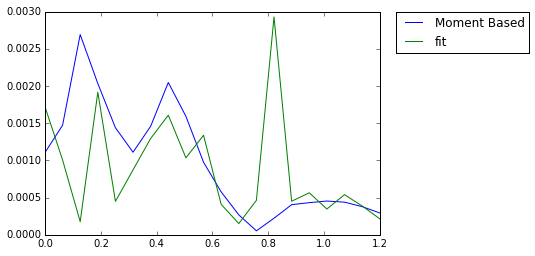

In [35]:
plt.plot(redshifts,np.abs(m_z_regaus),label='Moment Based')
plt.plot(redshifts, np.abs(m_z_fit),label='fit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('')

In [87]:
m_z_regaus2, m_z_sem2, m_z_fit2 =[],[],[]
redshifts=np.linspace(0.,1.2,3)
for z in redshifts:
    input_regauss2=args(shear_est='REGAUSS',npix=300)
    input_sem2    =args(shear_est='S13')
    input_fit2    =args(shear_est='fit',npix=300)
    m_z_regaus2.append(calc_cg_bias(input_regauss2))
    #m_z_sem2.append(calc_cg_bias(input_sem))
    m_z_fit2.append(calc_cg_bias(input_fit2))

6.49661728126e-08
0.0037342990005
6.49800517157e-08
90.4097069201
6.49746209932e-08
546.043092034
6.49699095865e-08
0.00373429903129
6.4982963857e-08
90.409708079
6.49929301515e-08
546.043098948
6.49773724969e-08
0.00373429927456
6.49677172945e-08
90.409706782
6.49813950426e-08
546.043089841
6.49834967274e-08
0.00373429926877
6.49702887511e-08
90.4097075212
6.49719321996e-08
546.043092855
6.49621296173e-08
0.00373429883014
6.49662461777e-08
90.4097066996
6.49814093201e-08
546.043093396
6.49703719103e-08
0.00373429908757
6.49811144728e-08
90.4097066694
6.49747696581e-08
546.043092107


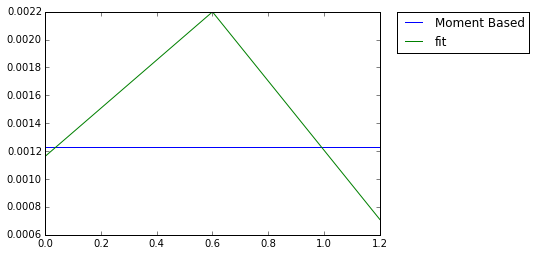

In [81]:
plt.plot(redshifts,np.abs(m_z_regaus2),label='Moment Based')
plt.plot(redshifts, np.abs(m_z_fit2),label='fit')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('')

In [ ]:
m_z_regaus, m_z_sem, m_z_fit =[],[],[]
redshifts=np.linspace(0.,1.2,8)
for z in redshifts:
    input_regauss=args(shear_est='REGAUSS',redshift=z)
    input_sem    =args(shear_est='S13',redshift=z)
    input_fit    =args(shear_est='fit',redshift=z)
    m_z_regaus.append(calc_cg_bias2(input_regauss))
    m_z_sem.append(calc_cg_bias2(input_sem))
    m_z_fit.append(calc_cg_bias2(input_fit))

In [ ]:
b_fracs=[0.05,0.15,0.25,0.35,0.45]
redshifts=np.linspace(0.,1.2,8)
fig=plt.figure(figsize=[14,12])
fig.subplots_adjust(left=0.2, wspace=0.6)
for b_frac in b_fracs:
    m_b_frac_reg=[]
    m_b_frac_s13=[]
    m_b_frac_fit=[]
    m_b_frac_fit2=[]   
    for z in redshifts:
        input_regauss=args(shear_est='REGAUSS',redshift=z,bulge_frac=b_frac)
        input_fit    =args(shear_est='fit'    ,redshift=z,bulge_frac=b_frac)
        m_b_frac_reg.append(calc_cg_bias2(input_regauss))
        m_b_frac_fit.append(calc_cg_bias2(input_fit))
    ax1 = fig.add_subplot(221)
    ax1.plot(redshifts,np.absolute(m_b_frac_reg),label='e_bulge={}'.format(b_frac))
    ax1.set_xlabel('redshift')
    ax1.set_ylabel('|m| with REGAUSS')
    ax2 = fig.add_subplot(222)
    ax2.plot(redshifts,np.absolute(m_b_frac_fit),label='e_bulge={}'.format(b_frac))
    ax2.set_xlabel('redshift')
    ax2.set_ylabel('|m| with fit')
    
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [88]:
m_z_im, m_z_sb, m_z_sc =[],[],[]
redshifts=np.linspace(0.,1.2,10)
for z in redshifts:
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Sbc'
    m_z_sb.append(calc_cg_bias(input_p))
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Scd'
    m_z_sc.append(calc_cg_bias(input_p))
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Im'
    m_z_im.append(calc_cg_bias(input_p))


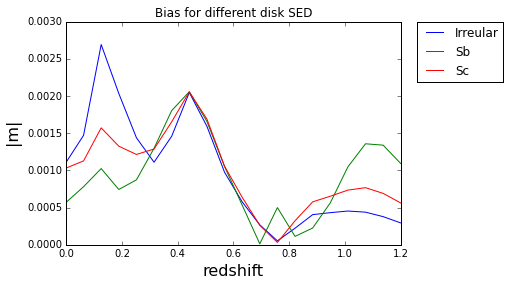

In [91]:
plt.plot(redshifts,np.abs(m_z_im),label='Irregular')
plt.plot(redshifts, np.abs(m_z_sb),label='Sb')
plt.plot(redshifts, np.abs(m_z_sc),label='Sc')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Bias for different disk SED; bulge SED: E')
plt.ylabel('|m|',size=16)
plt.xlabel('redshift',size=16)

In [159]:
class args():
    def __init__(self,npix=256,scale=0.2,
                 fwhm550=0.7,alpha=-0.2,
                 hlr_w=0.8,shear_est='REGAUSS',
                 redshift=0.3,res=1.,
                 disk_n=1.0,bulge_n=1.5,
                 disk_e=0.0,bulge_e=0.0,
                 bulge_HLR=0.17,disk_HLR=0.6,
                 bulge_frac=0.25,n_ring=3):
        self.npix=npix
        self.scale=scale
        self.fwhm550=fwhm550
        self.bulge_HLR=bulge_HLR
        self.disk_HLR=disk_HLR
        self.redshift=redshift
        self.bulge_n=bulge_n
        self.disk_n=disk_n
        self.bulge_e=bulge_e
        self.disk_e=disk_e
        self.bulge_frac=bulge_frac
        self.disk_SED='Sbc'
        self.bulge_SED='E'
        self.b_SED=None
        self.d_SED=None
        self.c_SED=None
        self.hlr_w=hlr_w
        self.bp=None
        self.shear_est=shear_est
        self.n_ring=n_ring
        self.alpha=alpha
        self.res=res
        self.T_flux=1.
        self.rt_g=[(0.01,0.01)]

In [ ]:
m_z_im, m_z_sb, m_z_sc =[],[],[]
redshifts=np.linspace(0.,1.2,30)
for z in redshifts:
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Sbc'
    m_z_sb.append(calc_cg_bias(input_p))
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Scd'
    m_z_sc.append(calc_cg_bias(input_p))
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Im'
    m_z_im.append(calc_cg_bias(input_p))



In [145]:
m_z_im, m_z_sb, m_z_sc =[],[],[]
redshifts=np.linspace(0.,1.2,2)
for z in redshifts:
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Sbc'
    m_z_sb.append(calc_cg_bias(input_p))
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Scd'
    m_z_sc.append(calc_cg_bias(input_p))
    input_p  =  args(shear_est='REGAUSS',redshift=z)
    input_p.disk_SED='Im'
    m_z_im.append(calc_cg_bias(input_p))




('z,galaxy FWHM (CG,noCG):', 0.0, 'Sbc', 0.90270333367641009, 0.90270333367641009, 0.78176401904467197)
('z,galaxy FWHM (CG,noCG):', 0.0, 'Scd', 0.90270333367641009, 0.90270333367641009, 0.78176401904467197)
('z,galaxy FWHM (CG,noCG):', 0.0, 'Im', 0.90270333367641009, 0.90270333367641009, 0.78176401904467197)
('z,galaxy FWHM (CG,noCG):', 1.2, 'Sbc', 1.1055812783082737, 1.1055812783082737, 0.78176401904467197)
('z,galaxy FWHM (CG,noCG):', 1.2, 'Scd', 1.1507254783503185, 1.1507254783503185, 0.78176401904467197)
('z,galaxy FWHM (CG,noCG):', 1.2, 'Im', 1.2766152972845848, 1.2766152972845848, 0.78176401904467197)


In [ ]:
plt.plot(redshifts,np.abs(m_z_im),label='Irregular')
plt.plot(redshifts, np.abs(m_z_sb),label='Sb')
plt.plot(redshifts, np.abs(m_z_sc),label='Sc')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Bias for different disk SED; bulge SED: E')
plt.ylabel('|m|',size=16)
plt.xlabel('redshift',size=16)

In [152]:
0.6*1.4


0.84